In [1]:
import os 
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, HTML
from keras.src.applications.resnet import ResNet50, ResNet152
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

## Data Extraction


In [ ]:
# Path to the zip file
zip_file_path = 'Dataset-zip\AIA-image-classification-6.zip'

# Path to the dataset folder
dataset_folder = '.\Dataset-org'

# Create the dataset folder if it doesn't exist
os.makedirs(dataset_folder, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

print(f"Data extracted to {dataset_folder}")

Data extracted to .\Dataset-org


In [ ]:
# Paths
csv_path = r'Dataset-org/AIA image classification/upload/images.csv'
images_folder = r'Dataset-org/AIA image classification/upload/images/images'
output_folder = r'Dataset-labeled'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the CSV
df = pd.read_csv(csv_path)

# Iterate over rows in the CSV
for _, row in df.iterrows():
    image_name = row['image_name']  # CSV has column 'image_name'
    label = str(row['label'])  # CSV has column 'label'
    
    # Full path to the image file
    image_path = os.path.join(images_folder, image_name)
    
    # Directory for each label
    label_folder = os.path.join(output_folder, label)
    os.makedirs(label_folder, exist_ok=True)
    
    # Copy image to labeled folder
    if os.path.exists(image_path):
        shutil.copy(image_path, label_folder)
    else:
        print(f"Image {image_name} not found at {image_path}")

print("Images organized by label.")


Images organized by label.


## Visualization

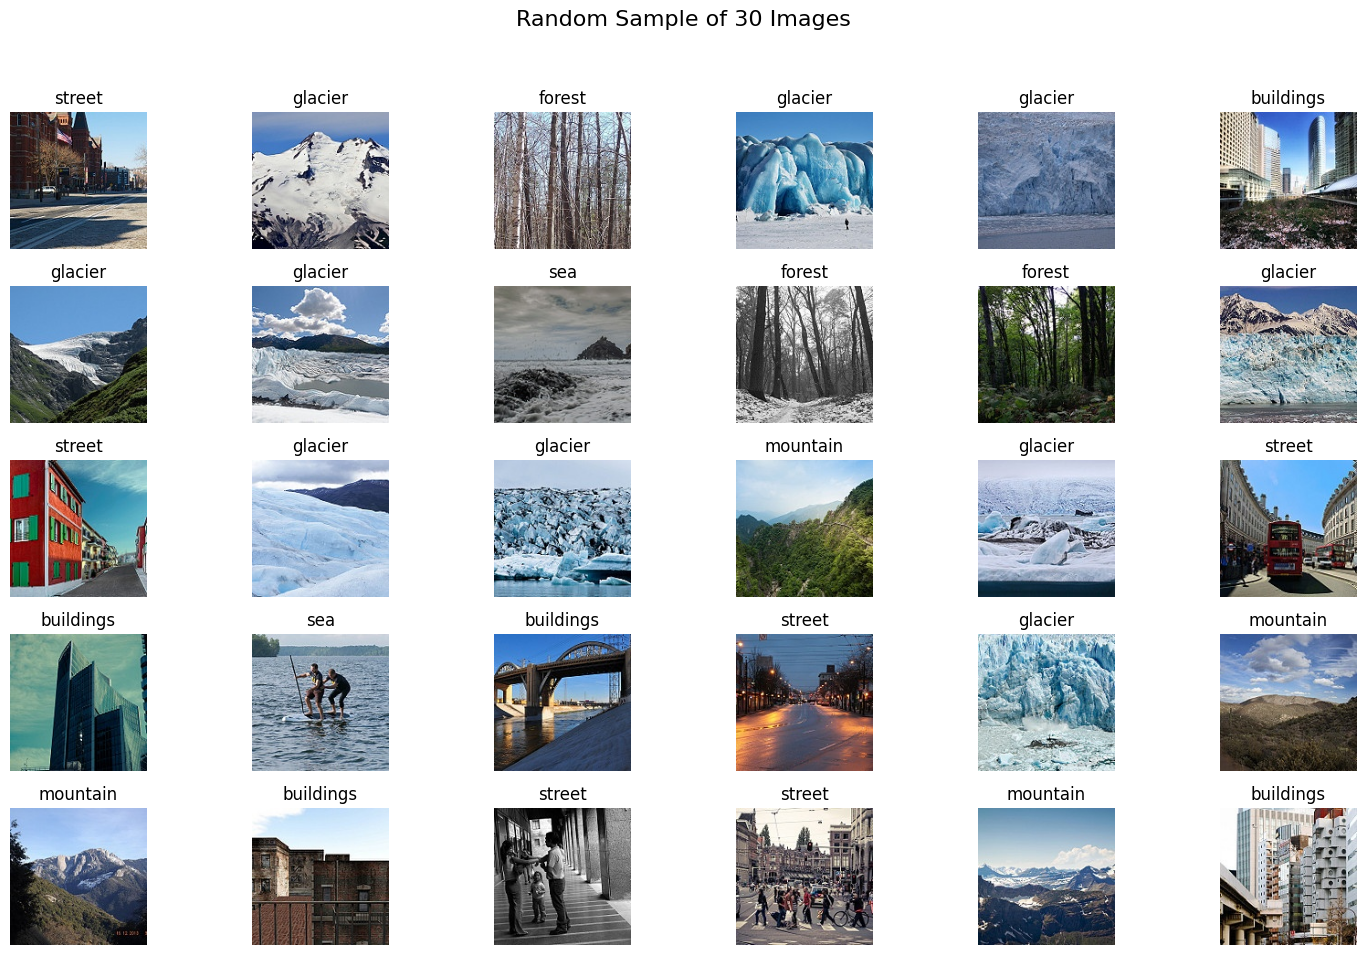

In [ ]:
# Paths
dataset_folder = 'Dataset-labeled'

# Class mapping (reverse mapping for folders to class names)
class_dict = {
    0: 'buildings',
    1: 'forest',
    2: 'glacier',
    3: 'mountain',
    4: 'sea',
    5: 'street'
}

# Collect all image paths with their labels
images_with_labels = []
for label, class_name in class_dict.items():
    class_folder = os.path.join(dataset_folder, str(label))
    
    if os.path.isdir(class_folder):
        # List all images in the folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            images_with_labels.append((image_path, class_name))

# Select 30 random images across all classes
selected_images = random.sample(images_with_labels, min(30, len(images_with_labels)))

# Plot the selected images
fig, axes = plt.subplots(5, 6, figsize=(15, 10))
fig.suptitle("Random Sample of 30 Images", fontsize=16)

for i, (image_path, class_name) in enumerate(selected_images):
    # Load image
    img = Image.open(image_path)
    
    # Get the appropriate subplot
    ax = axes[i // 6, i % 6]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # margins for left, right, top, bottom
plt.show()


## Train ,Test and Validation Split

In [ ]:
# Paths
source_folder = 'Dataset-labeled'
output_folder = 'Dataset-split'
os.makedirs(output_folder, exist_ok=True)

# Class mapping
class_dict = {
    0: 'buildings',
    1: 'forest',
    2: 'glacier',
    3: 'mountain',
    4: 'sea',
    5: 'street'
}

# Prepare image paths and labels
images = []
labels = []

for label, class_name in class_dict.items():
    class_folder = os.path.join(source_folder, str(label))
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            images.append(os.path.join(class_folder, image_name))
            labels.append(class_name)

# Split into train (70%) and temp (30%) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)

# Further split temp into validation (15%) and test (15%) sets
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Define helper function to copy images
def copy_images(image_paths, labels, split):
    for img_path, label in zip(image_paths, labels):
        # Create class directory if it doesn't exist
        dest_dir = os.path.join(output_folder, split, label)
        os.makedirs(dest_dir, exist_ok=True)
        
        # Copy the image
        shutil.copy(img_path, dest_dir)

# Copy images into train, validation, and test folders
copy_images(train_images, train_labels, 'train')
copy_images(val_images, val_labels, 'validation')
copy_images(test_images, test_labels, 'test')

print("Dataset split into train, validation, and test sets.")


Dataset split into train, validation, and test sets.


In [ ]:
# Path to the main split folder
output_folder = 'Dataset-split'

# Initialize a dictionary to store the count of images in each split and class
split_counts = {
    'train': {},
    'validation': {},
    'test': {}
}

# Iterate through each split folder and count images in each class subfolder
for split in split_counts.keys():
    split_folder = os.path.join(output_folder, split)
    total_count = 0  # To keep track of the total number of images in this split
    print(f"\n{split.capitalize()} Set:")
    
    for class_name in os.listdir(split_folder):
        class_folder = os.path.join(split_folder, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            split_counts[split][class_name] = num_images
            total_count += num_images
            print(f"  {class_name}: {num_images} images")
    
    print(f"Total images in {split}: {total_count}")


Train Set:
  buildings: 1534 images
  forest: 1589 images
  glacier: 1683 images
  mountain: 1758 images
  sea: 1592 images
  street: 1667 images
Total images in train: 9823

Validation Set:
  buildings: 329 images
  forest: 341 images
  glacier: 360 images
  mountain: 377 images
  sea: 341 images
  street: 357 images
Total images in validation: 2105

Test Set:
  buildings: 328 images
  forest: 341 images
  glacier: 361 images
  mountain: 377 images
  sea: 341 images
  street: 358 images
Total images in test: 2106


In [10]:
IMG_SIZE = (256, 256, 3)
NUM_CLASSES = 6
BATCH_SIZE = 192
EPOCHS = 50

## Data Pipelines

In [11]:
# Data augmentation and rescaling for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_data = train_datagen.flow_from_directory(
    'Dataset-split/train',
    target_size=(256, 256),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    'Dataset-split/validation',
    target_size=(256, 256),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load test data
test_data = test_datagen.flow_from_directory(
    'Dataset-split/test',
    target_size=(256, 256),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Shuffle=False to keep order consistent for evaluation
)

Found 9823 images belonging to 6 classes.
Found 2105 images belonging to 6 classes.
Found 2106 images belonging to 6 classes.


## InceptionV3 model

In [20]:
InceptionV3 = tf.keras.applications.InceptionV3(include_top= False, input_shape= IMG_SIZE, weights= 'imagenet')
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
    
model.add(InceptionV3)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_474 (Conv2D)             │ (None, 4, 4, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_474         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,524,198 (101.18 MB)

 Trainable params: 4,720,902 (18.01 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

In [21]:
# model compilation
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

## Callbacks

In [22]:
checkpoint = ModelCheckpoint(
    'Inception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
)

reduceLR = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=1,
    verbose=1, 
)

callbacks = [checkpoint, earlystop, reduceLR]


## Model training

In [23]:
# Train the model
history = model.fit(
    train_data, 
    epochs = EPOCHS,
    validation_data = val_data, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7408 - loss: 0.8071 
Epoch 1: val_loss improved from inf to 0.33139, saving model to Inception_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1303s 25s/step - accuracy: 0.7423 - loss: 0.8023 - val_accuracy: 0.8855 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8692 - loss: 0.3670 
Epoch 2: val_loss improved from 0.33139 to 0.29461, saving model to Inception_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1424s 27s/step - accuracy: 0.8692 - loss: 0.3669 - val_accuracy: 0.8945 - val_loss: 0.2946 - learning_rate: 1.0000e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8750 - loss: 0.3518 
Epoch 3: val_loss improved from 0.29461 to 0.26510, saving model to Inception_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1504s 29s/step - accuracy: 0.8751 - loss: 0.3516 - val_accuracy: 0.9021 - val_loss: 0.2651 - learning_rate: 1.0000e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 

## Test loss and accuracy

In [24]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 220s 20s/step - accuracy: 0.9368 - loss: 0.2006
Test Accuracy: 0.92


## Visualizatuion of train loss and accuracy , validation loss and accuracy

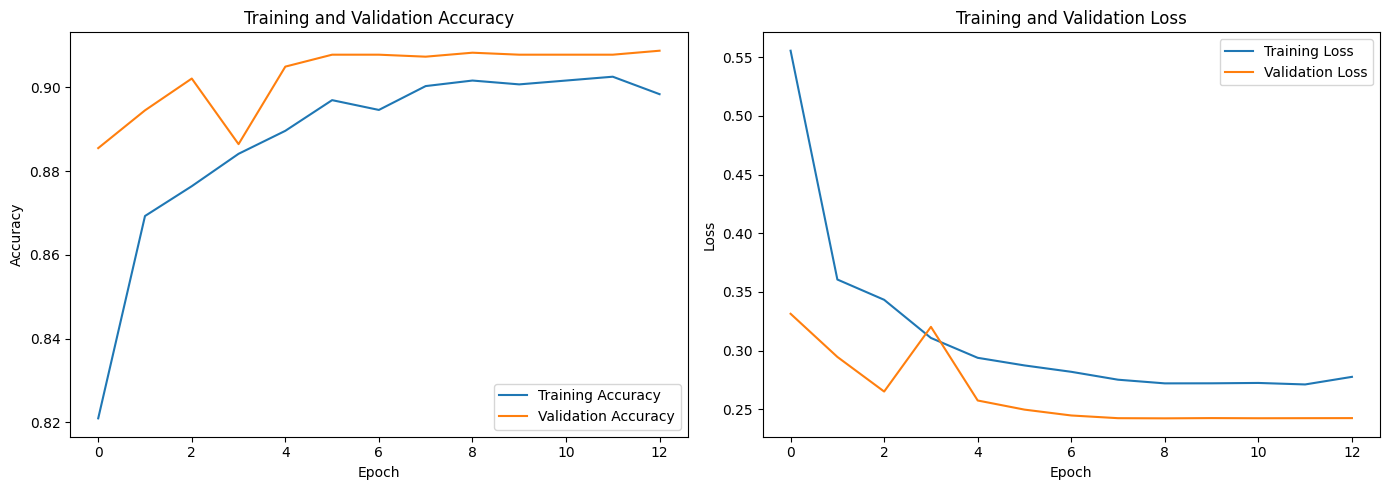

In [25]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Prediction

In [28]:
# Predicting on test set
y_pred = np.argmax(model.predict(test_data), axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 242s 21s/step


## Confusion matrix

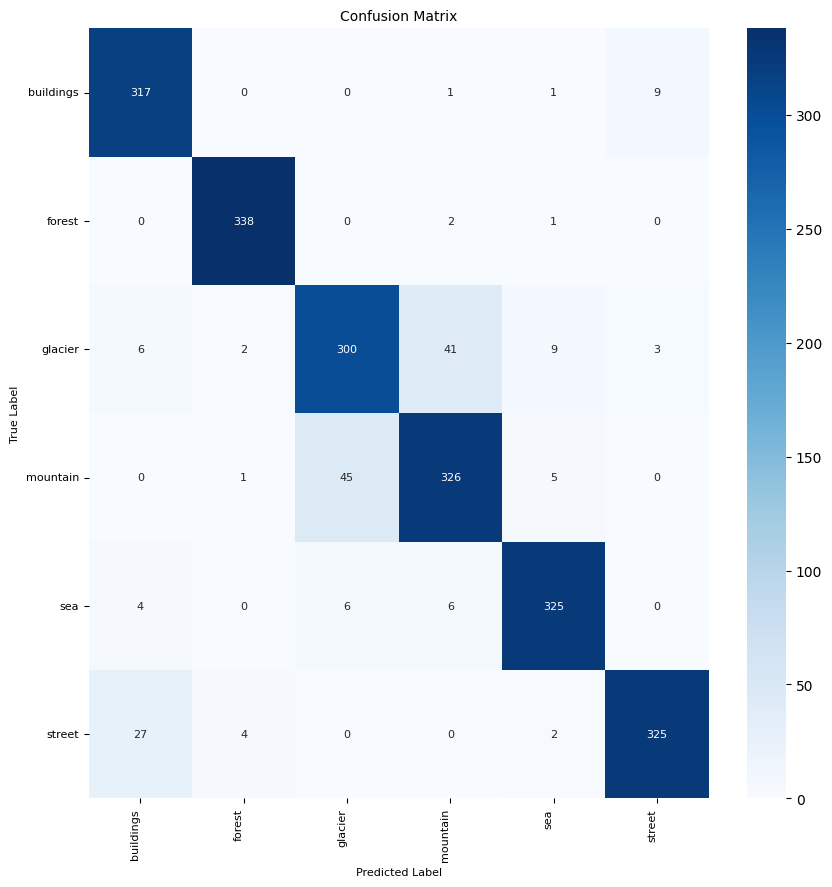

In [36]:
# Get the true labels
test_labels = test_data.classes

# confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 10))

#class labels
class_names = list(test_data.class_indices.keys())

# confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8} )
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate x labels and adjust font size
plt.yticks(rotation=0, fontsize=8) 
plt.xlabel('Predicted Label', fontsize=8)
plt.ylabel('True Label', fontsize=8)
plt.title('Confusion Matrix', fontsize=10)

# Save the figure as a image file
plt.show()

## Classification report

In [37]:
# classification Report
print(classification_report(test_labels, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.90      0.97      0.93       328
      forest       0.98      0.99      0.99       341
     glacier       0.85      0.83      0.84       361
    mountain       0.87      0.86      0.87       377
         sea       0.95      0.95      0.95       341
      street       0.96      0.91      0.94       358

    accuracy                           0.92      2106
   macro avg       0.92      0.92      0.92      2106
weighted avg       0.92      0.92      0.92      2106



## VGG16 model

In [3]:
IMG_SIZE = (128, 128, 3)
NUM_CLASSES = 6
BATCH_SIZE = 256
EPOCHS = 50

## Data pipeline

In [4]:
# Data augmentation and rescaling for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_data = train_datagen.flow_from_directory(
    'Dataset-split/train',
    target_size=(128, 128),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    'Dataset-split/validation',
    target_size=(128, 128),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load test data
test_data = test_datagen.flow_from_directory(
    'Dataset-split/test',
    target_size=(128, 128),
    color_mode= 'rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Shuffle=False to keep order consistent for evaluation
)

Found 9823 images belonging to 6 classes.
Found 2105 images belonging to 6 classes.
Found 2106 images belonging to 6 classes.


## VGG16 model

In [9]:
VGG16 = tf.keras.applications.VGG16(include_top= False, input_shape= IMG_SIZE, weights= 'imagenet')
model = Sequential()

for layer in VGG16.layers:
    layer.trainable= False
    
model.add(VGG16)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES,activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,897,158 (60.64 MB)

 Trainable params: 1,181,958 (4.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [10]:
# model compilation
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

## Callbacks

In [11]:
checkpoint = ModelCheckpoint(
    'VGG16_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
)

reduceLR = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=1,
    verbose=1, 
)

callbacks = [checkpoint, earlystop, reduceLR]

## Model training

In [12]:
# Train the model
history = model.fit(
    train_data, 
    epochs = EPOCHS,
    validation_data = val_data, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.4702 - loss: 1.5574 
Epoch 1: val_loss improved from inf to 1.13172, saving model to VGG16_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1315s 34s/step - accuracy: 0.4738 - loss: 1.5458 - val_accuracy: 0.5610 - val_loss: 1.1317 - learning_rate: 1.0000e-04
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.7587 - loss: 0.6641 
Epoch 2: val_loss improved from 1.13172 to 0.79519, saving model to VGG16_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1307s 34s/step - accuracy: 0.7588 - loss: 0.6639 - val_accuracy: 0.7449 - val_loss: 0.7952 - learning_rate: 1.0000e-04
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7921 - loss: 0.5803 
Epoch 3: val_loss improved from 0.79519 to 0.62339, saving model to VGG16_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1291s 33s/step - accuracy: 0.7921 - loss: 0.5803 - val_accuracy: 0.8318 - val_loss: 0.6234 - learning_rate: 1.0000e-04
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - a

## Test Accuracy and loss

In [13]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 202s 21s/step - accuracy: 0.8904 - loss: 0.3328
Test Accuracy: 0.86


## Visualization of train accuracy and loss, validation accuracy and loss

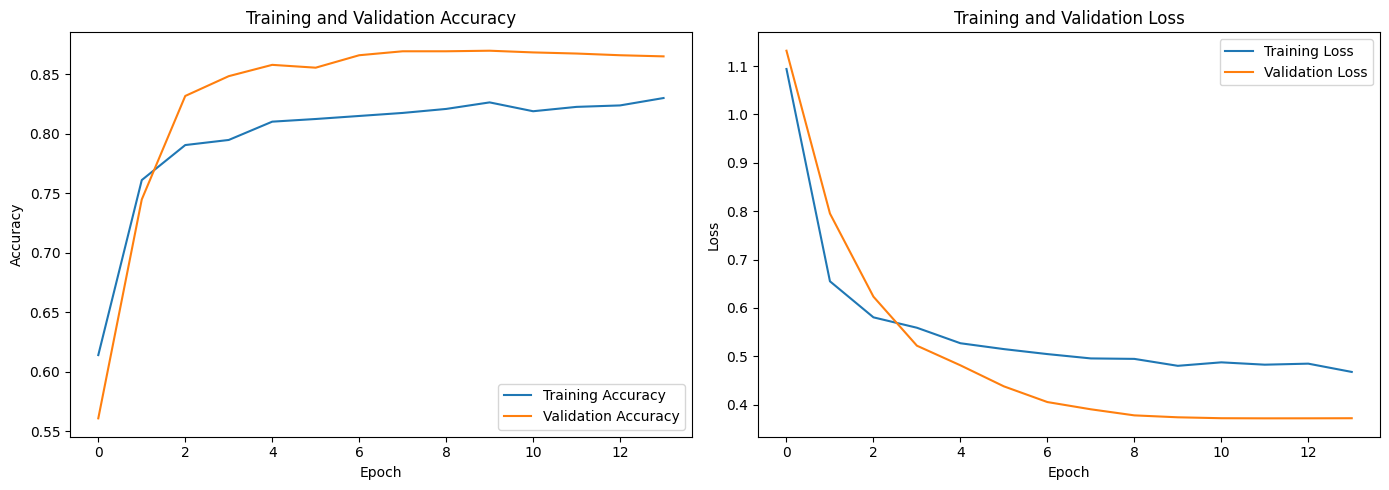

In [14]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model prediction

In [16]:
# Predicting on test set
y_pred = np.argmax(model.predict(test_data), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 232s 24s/step


## Confusion matrix

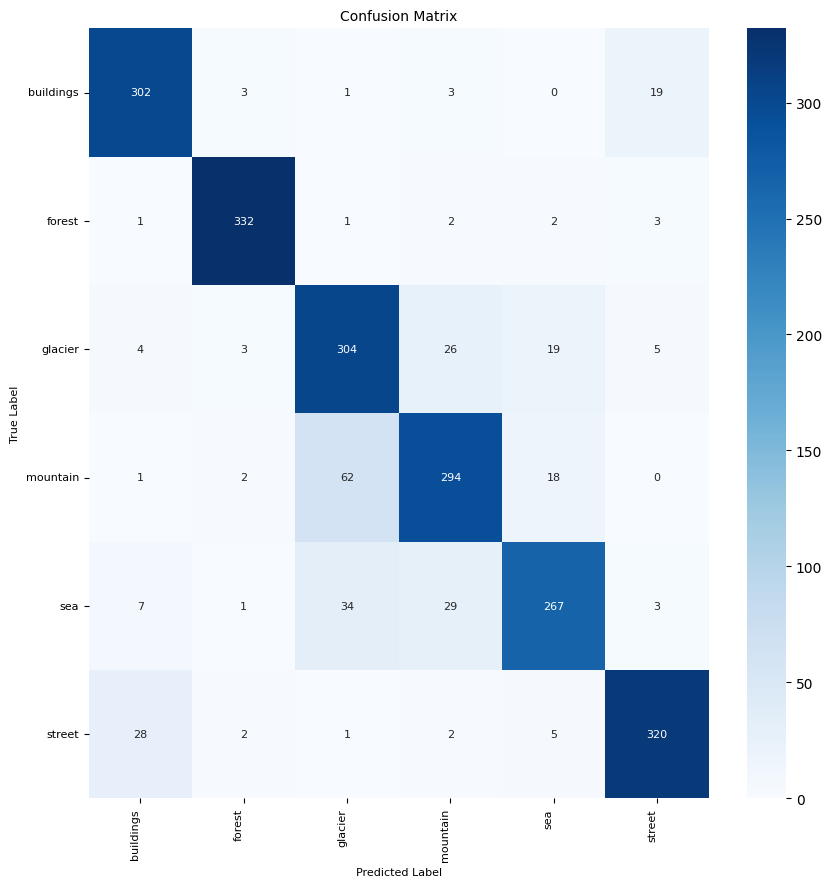

In [17]:
# Get the true labels
test_labels = test_data.classes

# confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 10))

#class labels
class_names = list(test_data.class_indices.keys())

# confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8} )
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate x labels and adjust font size
plt.yticks(rotation=0, fontsize=8) 
plt.xlabel('Predicted Label', fontsize=8)
plt.ylabel('True Label', fontsize=8)
plt.title('Confusion Matrix', fontsize=10)

# Save the figure as a image file
plt.show()

## Classifiaction Report

In [18]:
# classification Report
print(classification_report(test_labels, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.88      0.92      0.90       328
      forest       0.97      0.97      0.97       341
     glacier       0.75      0.84      0.80       361
    mountain       0.83      0.78      0.80       377
         sea       0.86      0.78      0.82       341
      street       0.91      0.89      0.90       358

    accuracy                           0.86      2106
   macro avg       0.87      0.87      0.87      2106
weighted avg       0.87      0.86      0.86      2106

